# Студент гр. РИМ–181228 
# Шубин Дмитрий
# Сегментация изображений
**Сегментация изображений** – это процесс разделения цифрового изображения на несколько сегментов, чтобы упростить и / или изменить представление изображения на что-то более значимое и более простое для анализа.

Классификация алгоритмов сегментации изображений приведена на рисунке ниже.
![](https://habrastorage.org/webt/zi/93/f7/zi93f7mpnuzuyo_evzeu6jqzxgo.png)

**Сегментация с учителем**: для сегментации используются данные из человеческого ввода.

**Сегментация без учителя**: предварительных знаний не требуется, алгоритмы пытаются автоматически разделить изображения на значимые области. Пользователь по-прежнему может настраивать определенные параметры для получения желаемых результатов.
## Импорт необходимых библиотек и модулей

In [1]:
import numpy as np
from skimage import data
from skimage.feature import canny
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.filters import sobel, try_all_threshold
from skimage.filters.thresholding import threshold_adaptive, threshold_local
from skimage.morphology import watershed
from scipy import ndimage as ndi
from skimage.color import label2rgb, rgb2gray
from skimage.filters import sobel
from skimage.morphology import watershed
from skimage import io
from skimage.segmentation import active_contour, random_walker, slic, felzenszwalb
from skimage.draw import circle_perimeter
import cv2

## 2a. [Обзор методов сегментации изображений в библиотеке scikit-image](https://habr.com/ru/post/441006/)
### 2a.1. Обзор изображений в Python
#### Импорт изображений из библиотеки skimage
Модуль данных `skimage` содержит несколько встроенных примеров наборов данных в формате jpeg или png.

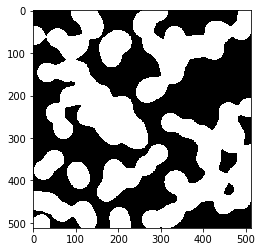

In [2]:
image = data.binary_blobs()
plt.imshow(image, cmap = 'gray');

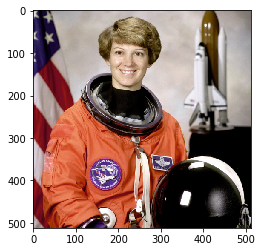

In [3]:
image = data.astronaut()
plt.imshow(image);

#### Импорт изображения из внешнего источника

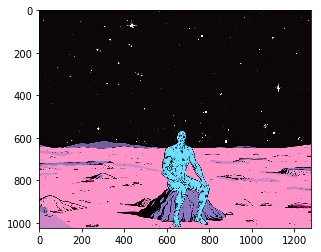

In [4]:
image = io.imread('images/3.jpg')
plt.imshow(image);

#### Загрузка нескольких изображений

In [5]:
images = io.ImageCollection('images/*.jpg')
print('Тип переменной images:', type(images), '\nДлина переменной images (кол-во изображений в коллекции):', len(images))
print('Изображения:', images.files)

Тип переменной images: <class 'skimage.io.collection.ImageCollection'> 
Длина переменной images (кол-во изображений в коллекции): 5
Изображения: ['images/1.jpg', 'images/1_test.jpg', 'images/2.jpg', 'images/3.jpg', 'images/books.jpg']


#### Сохранение изображений

In [6]:
io.imsave('images/1_test.jpg', image)

### 2a.2. Сегментация изображений

Возможно, реально выбрать значение из исходного изображение, которое даст разумную сегментацию без сложных алгоритмов. Для этого используется гистограмма.

Гистограмма показывает количество пикселей в изображении с различными значениями интенсивности, найденными в этом изображении. Проще говоря, гистограмма — это график, на котором ось X показывает все значения, которые есть на изображении, а ось Y показывает частоту этих значений.

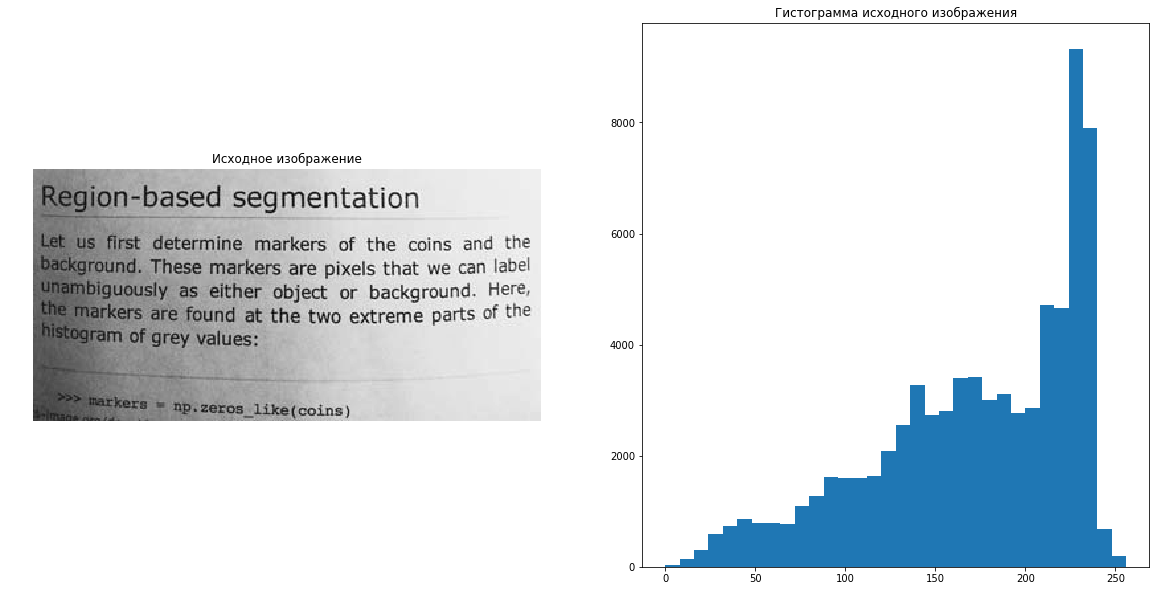

In [7]:
text = data.page()

fig, axes = plt.subplots(1, 2, figsize = (20, 10))
axes[0].imshow(text, cmap = 'gray')
axes[0].set_title('Исходное изображение');
axes[0].axis('off')
axes[1].hist(text.ravel(), bins = 32, range = [0, 256])
axes[1].set_title('Гистограмма исходного изображения');

Данный пример – 8-битное изображение, поэтому по оси X 256 возможных значений. По гистограмме видно, что существует концентрация довольно светлых пикселей (0: черный, 255: белый). Скорее всего, это довольно светлый текстовый фон, но остальное немного размыто. 

Идеальная гистограмма сегментации была бы бимодальной, чтобы было возможно выбрать число посередине. 
#### Контролируемый порог
**Thresholding** самый простой способ отделить объекты от фона, выбрав пиксели выше или ниже определенного порога. Используется, когда нужно сегментировать объекты по их фону. 

**Контролируемый порог** – пороговое значение выбирается самостоятельно. 

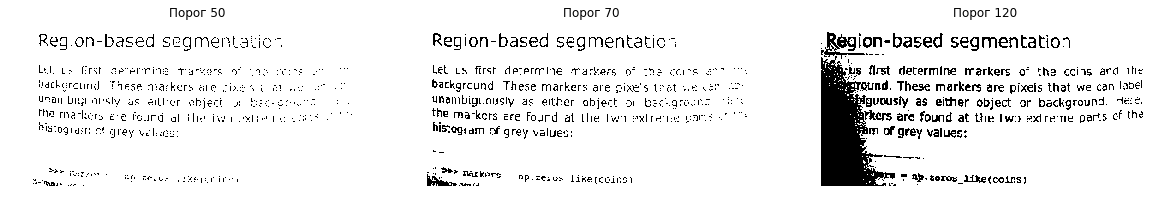

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (20, 10))
axes[0].imshow(text > 50, cmap = 'gray')
axes[0].axis('off')
axes[0].set_title('Порог 50');
axes[1].imshow(text > 70, cmap = 'gray')
axes[1].axis('off')
axes[1].set_title('Порог 70');
axes[2].imshow(text > 120, cmap = 'gray')
axes[2].axis('off')
axes[2].set_title('Порог 120');

Достойных результатов не получено.

#### Неконтролируемый порог
 
**Неконтролируемый порог**: на основе определенных методов (isodata, li, mean и т.д.) порог определяется автоматически.

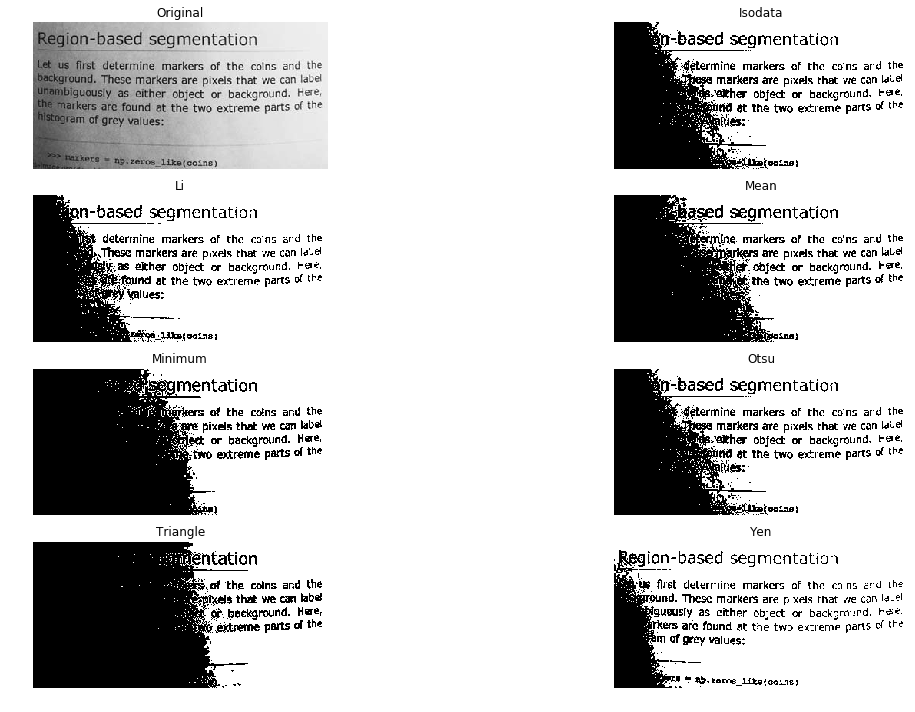

In [9]:
fig, axes = try_all_threshold(text, figsize = (20, 10), verbose = False)
plt.show()

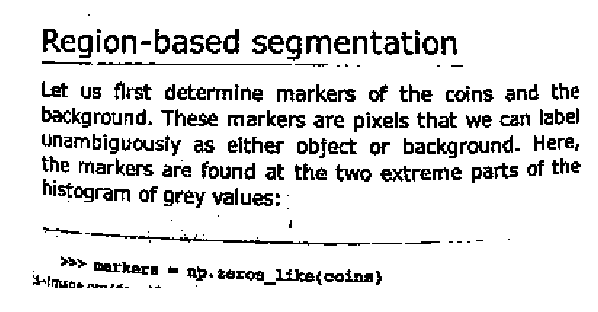

In [10]:
text_threshold = threshold_local(text, block_size = 51, offset = 10) 
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(text > text_threshold, cmap = 'gray');

С помощью локального порога достигнут хороший результат.
#### Сегментация с алгоритмом для модели с учителем
Для сегментации высококонтрастного изображения нужны более совершенные инструменты, чем thresholding.

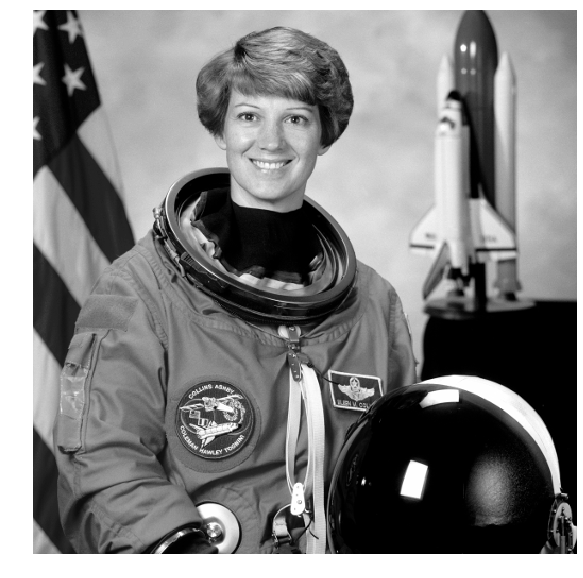

In [11]:
image = data.astronaut() # загрузим изображение
image_gray = rgb2gray(image) # преобразуем в оттенки серого
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(image_gray, cmap = 'gray');

##### Активная контурная сегментация
**Сегментация активного контура** ("змея") инициализируется с использованием определенного пользователем контура или линии вокруг интересующей области, а затем этот контур медленно сжимается и притягивается или отталкивается от света и краев.

В данном примере для инициализации змеи вокруг головы человека нарисован круг.

In [12]:
def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image. Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2 * np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [100, 225], 94)[:-1]

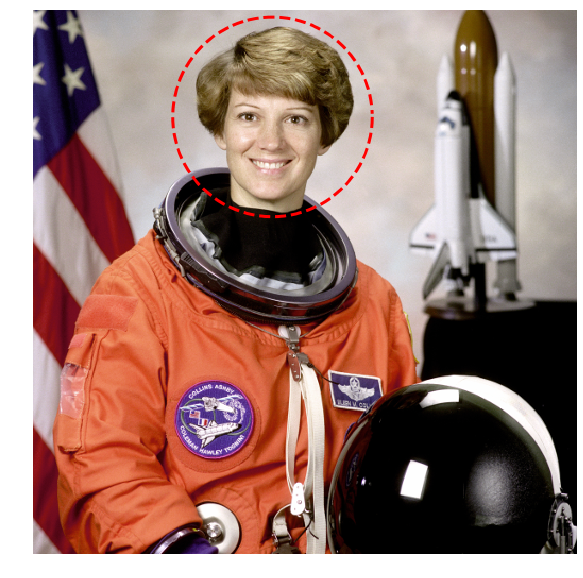

In [13]:
fig, axes = plt.subplots(1, 1, figsize = (10, 10))
axes.plot(points[:, 0], points[:, 1], '--r', lw=3)
axes.axis('off')
axes.imshow(image);

Алгоритм сегментирует лицо человека от остальной части изображения, подгоняя замкнутую кривую к краям лица.

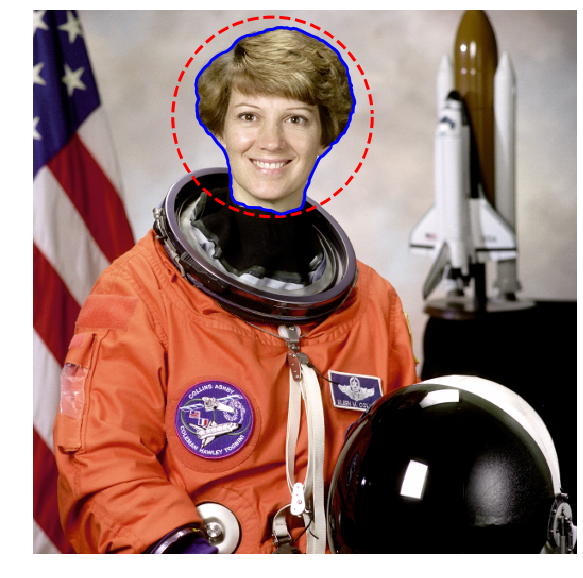

In [14]:
snake = active_contour(image_gray, points,alpha = 0.06, beta = 0.3)

fig, axes = plt.subplots(1, 1, figsize = (10, 10))
axes.plot(points[:, 0], points[:, 1], '--r', lw=3)
axes.axis('off')
axes.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
axes.imshow(image);

##### Сегментация случайного прохождения (Random walker algorithm)
Пользователь интерактивно помечает небольшое количество пикселей известными метками, например, «объект» и «фон». Для немаркированных пикселей вычисляется вероятность того, к какой из меток он пренадлежит. Таким образом, проводится сегментация изображения.

Здесь использованы предыдущие значения из данного примера. Инициализации могут быть разные, но для простоты выбраны круги. Алгоритм случайного прохождения принимает метки в качестве ввода. Таким образом, объявлен большой круг, охватывающий все лицо человека, и еще один меньший круг около середины лица.

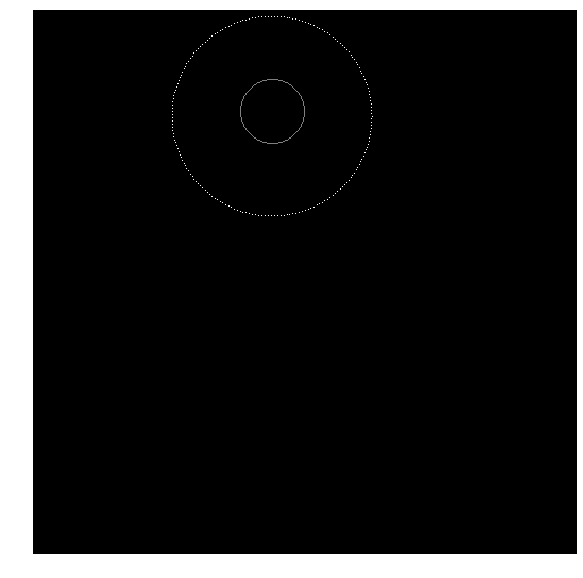

In [15]:
image_labels = np.zeros(image_gray.shape, dtype = np.uint8)
indices = circle_perimeter(95, 225, 30)
image_labels[indices] = 1
image_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(image_labels, cmap = 'gray');

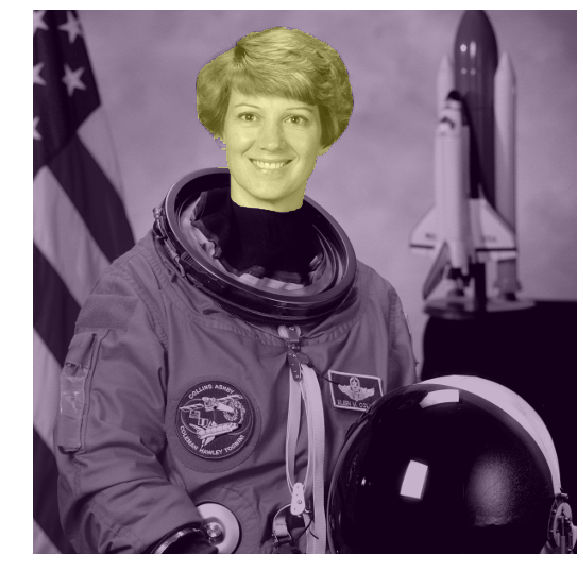

In [16]:
image_segmented = random_walker(image_gray, image_labels, beta = 5000)

fig, axes = plt.subplots(1, 1, figsize = (10, 10))
axes.imshow(image_gray, cmap = 'gray')
axes.axis('off')
axes.imshow(image_segmented == 1, alpha = 0.3);

#### Сегментация без учителя
##### Простая линейно-итеративная кластеризация (Simple Linear Iterative Clustering или SLIC)
**SLIC** использует алгоритм машинного обучения K-means. Он принимает все значения пикселей изображения и пытается разделить их на заданное количество подобластей. 

In [17]:
image_slic = slic(image, n_segments = 155)

Все, что нужно сделать, это просто установить для каждого найденного сегмента среднее значение, что делает его больше похожим на изображение.

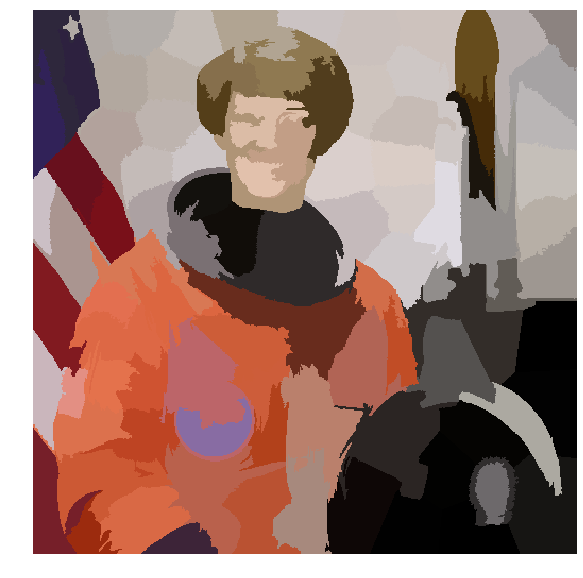

In [18]:
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(label2rgb(image_slic, image, kind = 'avg'));

##### Felzenszwalb
**Felzenszwalb** использует алгоритм кластеризации minimum-spanning tree clustering. Felzenszwaib не сообщает точное количество кластеров, на которые будет разделено изображение. Он будет генерировать столько кластеров, сколько он считает нужным для этого.

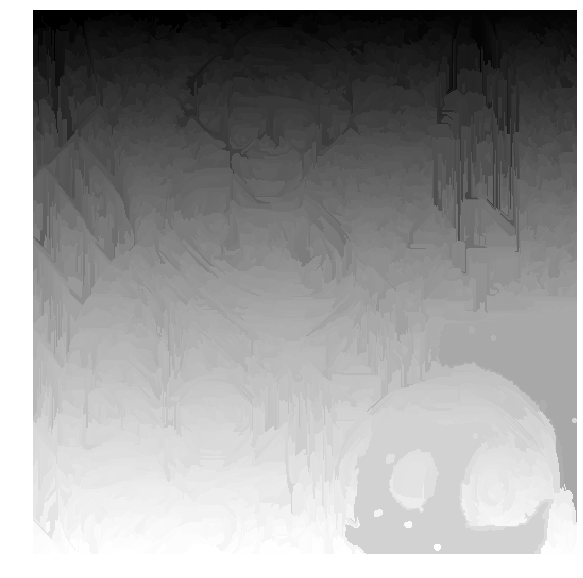

In [19]:
image_felzenszwalb = felzenszwalb(image) 

plt.figure(figsize = (10, 10))
plt.imshow(image_felzenszwalb, cmap = 'gray')
plt.axis('off');

На рисунке слишком много регионов. Определим количество уникальных сегментов.

In [20]:
np.unique(image_felzenszwalb).size

3295

Теперь их необходимо перекрасить, используя среднее значение по сегменту, как в алгоритме SLIC.

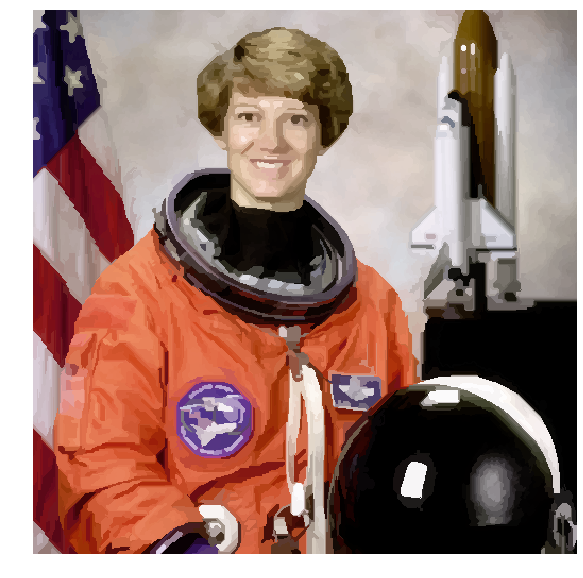

In [21]:
image_felzenszwalb_colored = label2rgb(image_felzenszwalb, image, kind = 'avg')
plt.figure(figsize = (10, 10))
plt.imshow(image_felzenszwalb_colored)
plt.axis('off');

## 2b. [Сегментация изображений](https://code-examples.net/ru/docs/scikit_image/user_guide/tutorial_segmentation)
Использовано изображение `coins` из `skimage.data`, на котором выделяются несколько монет на темном фоне. Сегментация монет не может быть выполнена из гистограммы значений серого, поскольку фон имеет достаточно серого уровня с монетами, что сегментация порога недостаточна.

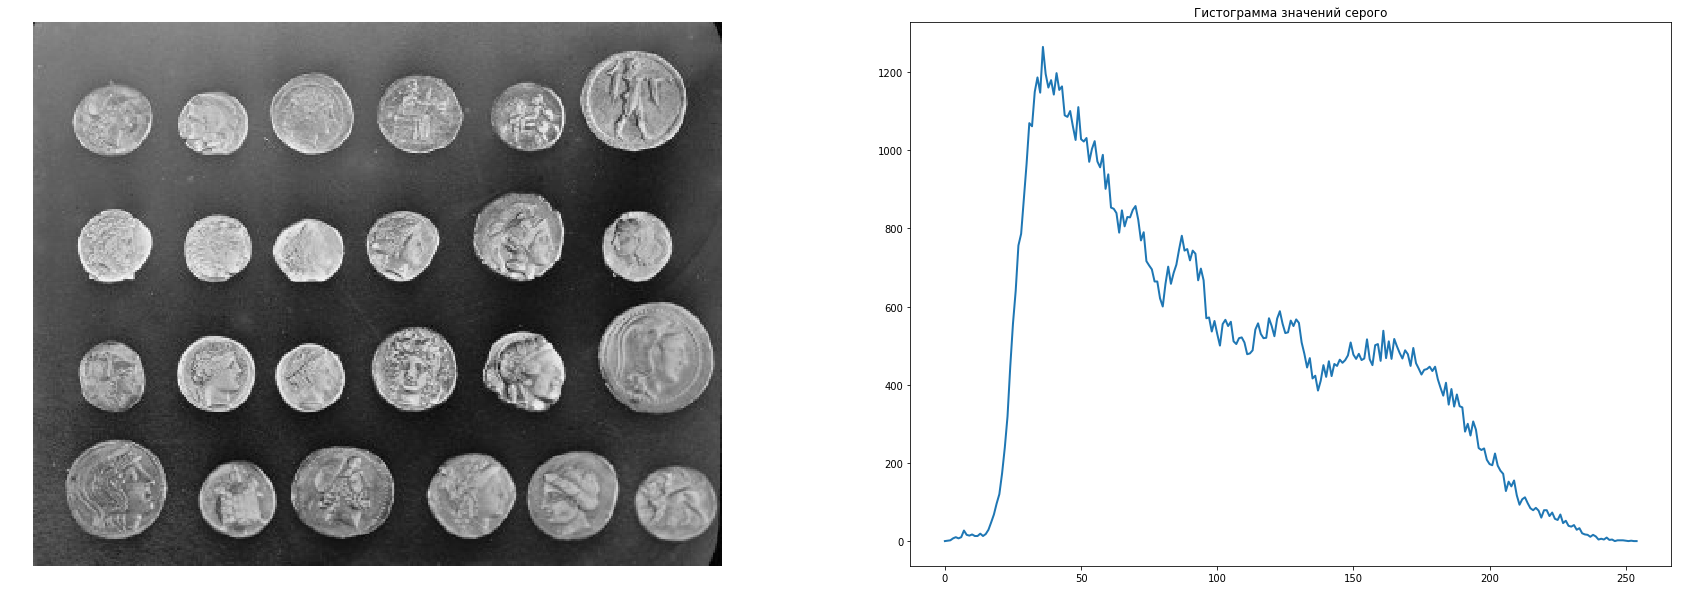

In [22]:
img_coins = data.coins()
hist = np.histogram(img_coins, bins = np.arange(0, 256))
fig, axes = plt.subplots(1, 2, figsize = (30, 10))
axes[0].imshow(img_coins, cmap = plt.cm.gray, interpolation = 'nearest')
axes[0].axis('off')
axes[1].plot(hist[1][:-1], hist[0], lw = 2)
axes[1].set_title('Гистограмма значений серого');

### 2b.1. Thresholding 
В данном случае пороговое изображение приводит либо к отсутствию значительных частей монет, либо к объединению частей фона с монетами. Это связано с неоднородным освещением изображения.

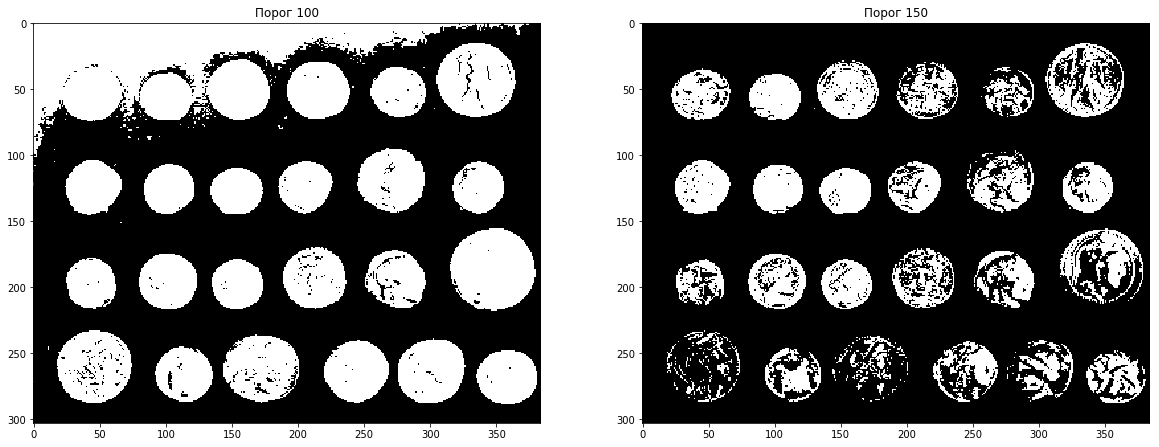

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
axes[0].imshow(img_coins > 100, cmap = plt.cm.gray)
axes[1].imshow(img_coins > 150, cmap = plt.cm.gray)
axes[0].set_title('Порог 100')
axes[1].set_title('Порог 150');

### 2b.2. Сегментация на основе краев
Использование градиента, а не серых значений, может дать лучший результат.

Для обнаружения крев, которые заключают монеты, использован детектор `canny` `skimage.feature.canny`, основанный на вычислении интенсивности градиентов для удаления шума, присутствующего на изображении. 

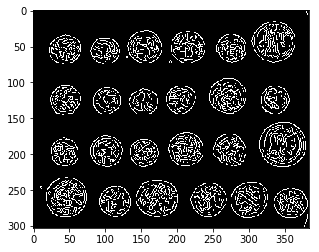

In [24]:
edges = canny(img_coins / 255.)
plt.imshow(edges, cmap = plt.cm.gray);

Теперь внутреннюю часть монет необходимо заполнить с помощью функции `ndi.binary_fill_holes`, которая использует математическую морфологию для заполнения отверстий.

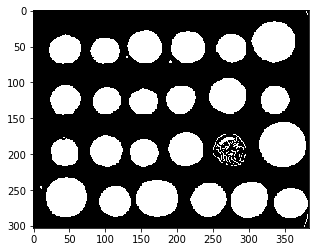

In [25]:
fill_coins = ndi.binary_fill_holes(edges)
plt.imshow(fill_coins, cmap = plt.cm.gray);

Большинство монет хорошо сегментированы на заднем плане. Маленькие объекты из фона можно легко удалить с помощью `ndi.label` для удаления объектов, меньших небольшого порога.

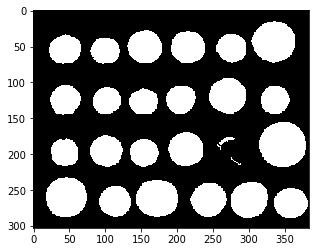

In [26]:
label_objects, nb_labels = ndi.label(fill_coins)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0
coins_cleaned = mask_sizes[label_objects]
plt.imshow(coins_cleaned, cmap = plt.cm.gray);

Однако сегментация не очень удовлетворительна, так как одна из монет не была полностью сегментирована. Причина в том, что контур, который был получен от детектора `canny`, не был полностью закрыт, поэтому функция заполнения не заполнила внутреннюю часть монеты.

Поэтому этот метод сегментации не очень устойчив: если был пропущен один пиксель контура объекта, заполнить его невозможно.

### 2b.3. Сегментация по регионам
Сначала необходимо определить **маркеры** монет и фона – пиксели, которые можно однозначно обозначать как объект или фон. Здесь маркеры находятся в двух крайних частях гистограммы серых значений.

In [27]:
markers = np.zeros_like(img_coins)
markers[img_coins < 30] = 1
markers[img_coins > 150] = 2

Эти маркеры используются для сегментации водораздела. Название водораздела происходит по аналогии с гидрологией. Преобразование водораздела наводняет изображение высоты, начиная с маркеров, чтобы определить водосборные бассейны этих маркеров. Водораздельные линии разделяют эти водосборные бассейны и соответствуют желаемой сегментации.

Выбор карты высот имеет решающее значение для хорошей сегментации. Здесь амплитуда градиента обеспечивает хорошую карту места, для вычисления амплитуды градиента используется оператор Собеля.

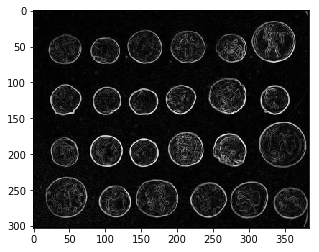

In [28]:
elevation_map = sobel(img_coins)
plt.imshow(elevation_map, cmap = plt.cm.gray);

Следующий шаг – найти маркеры фона и монет на основе крайних частей гистограммы серых значений.

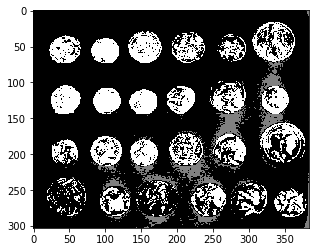

In [29]:
plt.imshow(markers, cmap = plt.cm.gray);

Теперь необходимо вычислить преобразование водораздела.

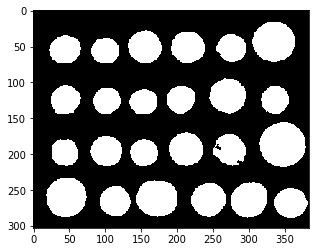

In [30]:
segmentation = watershed(elevation_map, markers)
plt.imshow(segmentation, cmap = plt.cm.gray);

С помощью этого метода результат удовлетворяет всем монетам. Даже если маркеры на фоне не были хорошо распределены, барьеры на карте высот были достаточно высокими, чтобы эти маркеры заливали весь фон.

Необходимо удалить несколько небольших отверстий с помощью математической морфологии.

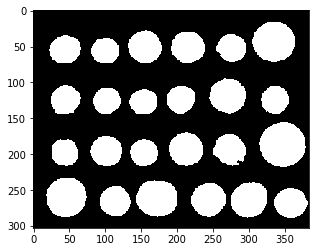

In [31]:
segmentation = ndi.binary_fill_holes(segmentation - 1)
plt.imshow(segmentation, cmap = plt.cm.gray);

Теперь нужно пометить все монеты используя `ndi.label`.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


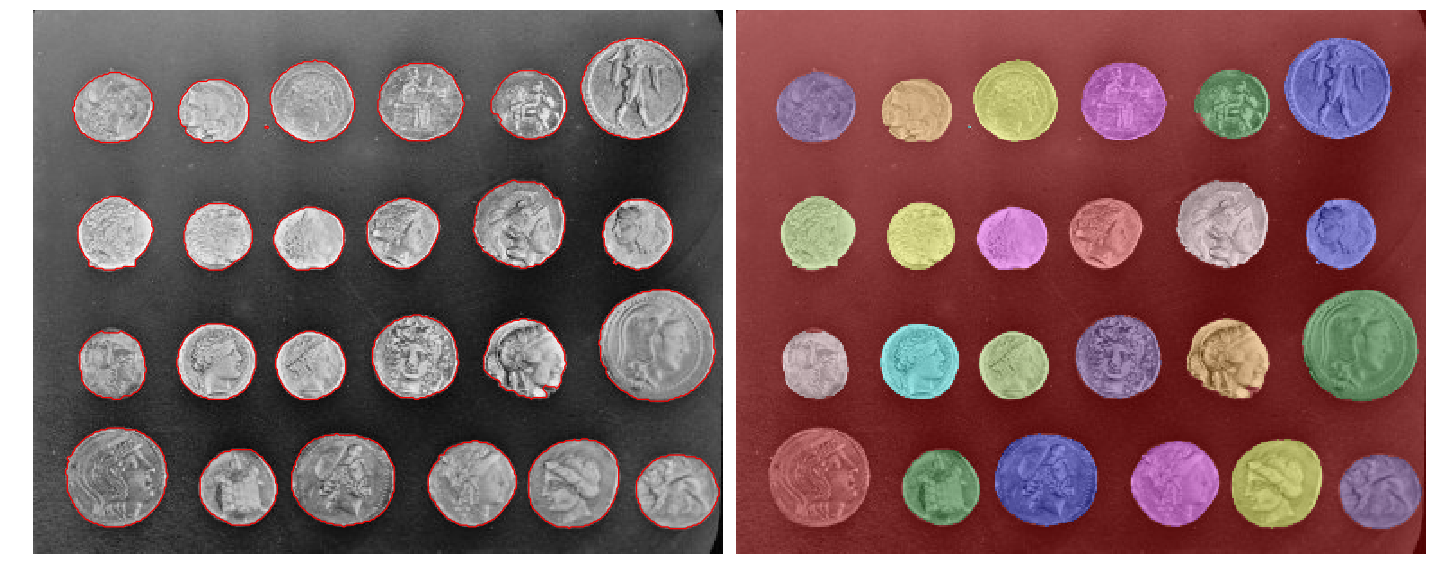

In [32]:
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=img_coins)

fig, axes = plt.subplots(1, 2, figsize = (20, 10), sharey = True)
axes[0].imshow(img_coins, cmap=plt.cm.gray, interpolation = 'nearest')
axes[0].contour(segmentation, [0.5], linewidths = 1.2, colors = 'r')
axes[1].imshow(image_label_overlay, interpolation = 'nearest')

for a in axes:
    a.axis('off')
    a.set_adjustable('box-forced')

plt.tight_layout();

## 3a. [Основные операции с изображениями в OpenCV 3 Python](https://arboook.com/kompyuternoe-zrenie/osnovnye-operatsii-s-izobrazheniyami-v-opencv-3-python/)
### 3a.1. Открытие локального файла в OpenCV 3 Python
Команда `imread()` возвращает NumPy массив, который содержит представление данных из изображения.

Метод для отображения `imshow()` принимает в себя два аргумента: 
1. Название окна, в котором будет отрисовано изображение.
2. Имя переменной, которая хранит данное изображение. 

Однако выполнение только данной команды отрисует изображение и сразу же закроет программу. 
Для того, чтобы изображение можно было увидеть и работать с ним, добавлена команда `waitKey(0)`. Данная команда останавливает выполнение скрипта до нажатия клавиши на клавиатуре. Параметр 0 означает что нажатие любой клавиши будет засчитано.

Команда `destroyAllWindows()` закрывает созданное окно.

In [39]:
image = cv2.imread("images/3.jpg")
cv2.imshow("Original image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 3a.2. Изменение размера изображения
Просмотреть разрешение оригинального изображения можно через атрибут изображения `shape`, который покажет размерность NumPy массива и, таким образом, разрешение снимка.

In [40]:
print(image.shape)

(1024, 1280, 3)


Изображение содержит 1024 строк, 1280 столбцов и 3 канала цвета.

Изображение шириной 1280 пикселей, сожмем его до ширины в 200 пикселей. 

Для этого необходимо задать итоговую ширину изображения (200 пикселей). Далее для сохранения исходных пропорций изображения нужно вычислить отношение новой ширины 200px и исходной 1280px = r. Умножение данного числа на исходную высоту даст новую высоту изображения.

Теперь изображение уменьшается методом `resize()`. Данный метод принимает три параметра и возвращает новое изображение: 
1. Исходное изображение.
2. Кортеж с требуемым разрешением для нового изображения.
3. Алгоритм, который будет использоваться для масштабирования.

In [41]:
# Необходимо сохранить соотношение сторон
# чтобы изображение не исказилось при уменьшении
# для этого вычисляется коэф. уменьшения стороны
final_wide = 200
r = float(final_wide) / image.shape[1]
dim = (final_wide, int(image.shape[0] * r))
 
# уменьшение изображения до подготовленных размеров
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
cv2.imshow("Resize image", resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 3a.3. Выбор нужного фрагмента изображения
Изображение обрезается с 514 по 1024 пиксель по высоте и с 385 по 895 пиксель по ширине. Высота идет первая (первыми идут строки, вторыми – столбцы).

In [42]:
# выбор участока изображения используя срезы
cropped = image[514:1024, 640-255:640+255]
cv2.imshow("Cropped image", cropped)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 3a.4. Поворот изображения на OpenCV 3 Python
Для этого необходимо получить размеры изображения через атрибут `shape` и срез по первым двум показателям – высоте и ширине. Далее выполняется вычисление середины картинки для передачи ее в матрицу вращения, чтобы изображение осталось в центре (необходимо поделить числа на 2).

Теперь нужно вычислить матрицу для преобразования с помощью метода `getRotationMatrix2D()`, который может использоваться как для поворота изображения, так и для изменения его размеров. Данный метод принимает три аргумента:
1. Кортеж с точкой, относительно которой будет осуществлен поворот изображения и изменение размера. 
2. Угол поворота, в градусах. 
3. Коэффициент увеличения. 

Метод возвращает матрицу поворота.

Метод `warpAffine()` использован для переворота изображения и принимает параметры:
1. Исходное изображение.
2. Матрица преобразования (здесь – матрицу поворота).
3. Кортеж с размерами выходного изображения.

Данный метод возвращает преобразованную картинку.

In [43]:
# получение размеров изображения для поворота
# и вычисление центра изображения
(h, w) = cropped.shape[:2]
center = (w / 2, h / 2)
 
# поворот изображения на 180 градусов
M = cv2.getRotationMatrix2D(center, 180, 1.0)
rotated = cv2.warpAffine(cropped, M, (w, h))
cv2.imshow("Rotated image", rotated)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 3a.5. Отражение изображения по осям
Метод `flip()` принимает два параметра:
1. Исходное изображение.
2. Ось для отражения: 0 – по вертикали, 1 – по горизонтали, (-1) – по вертикали и по горизонтали.

In [44]:
# отражение изображения по горизонтали
flip_image = cv2.flip(cropped, 1)
cv2.imshow("Flip image", flip_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 3a.6. Сохранение изображения на локальный диск с OpenCV и Python

In [45]:
# запись изображения на диск в формате png
cv2.imwrite("images/flip.png", flip_image)

True

## 3b. [Пишем скрипт для поиска книг на изображениях с помощью Python и OpenCV](https://tproger.ru/translations/finding-books-python-opencv/)
Загрузка изображения с диска обрабатывается функцией `cv2.imread`. Затем цвета изображения преобразуются из RGB в оттенки серого. Также изображение размывается, чтобы уменьшить высокочастотные шумы и повысить точность сегментации.

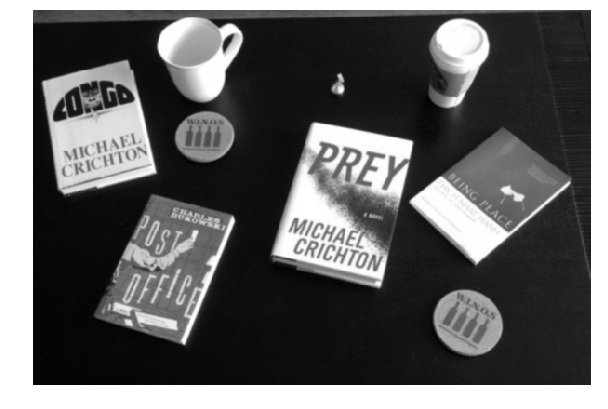

In [34]:
image = cv2.imread('images/books.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(gray, cmap = plt.cm.gray);

Теперь необходимо определить края (т.е. контуры) объектов на изображении.

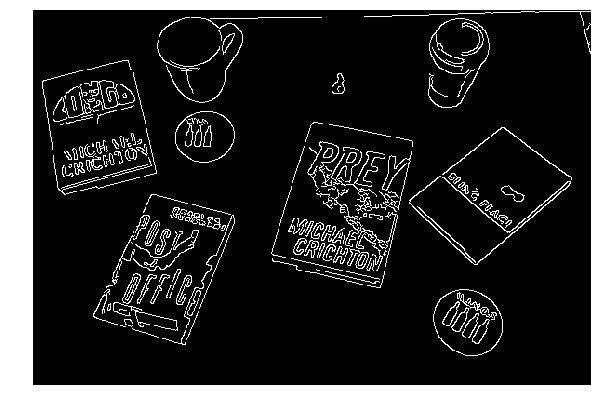

In [35]:
# распознавание контуров
edged = cv2.Canny(gray, 10, 250)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(edged, cmap = plt.cm.gray);

Некоторые из контуров не закрыты — между контурами существуют промежутки. Чтобы убрать промежутки между белыми пикселями изображения, необходимо применить операцию «закрытия».

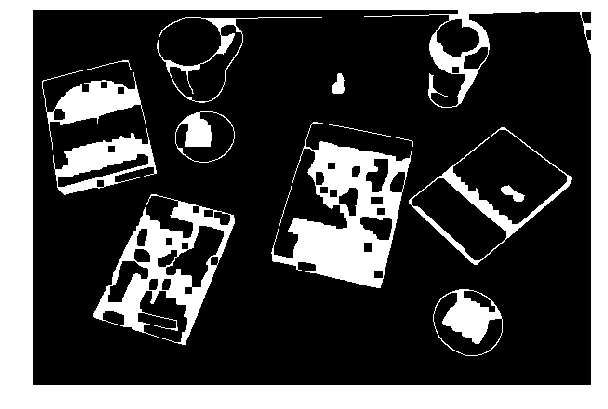

In [36]:
# создайте и примените закрытие
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(closed, cmap = plt.cm.gray);

Следующим шагом является фактическое обнаружение контуров объектов на изображении. Для этого используется функция `cv2.findContours`.

In [37]:
# найдите контуры в изображении и подсчитайте количество книг
(cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
total = 0

Книга представляет собой прямоугольник. У прямоугольника четыре вершины. Поэтому, если контур имеет четыре вершины, то можно предположить, что это книга.

Для каждого из контуров вычисляется периметр, с помощью `cv2.arcLength`, а затем контур апроксимируется (он может быть не идеальным прямоугольником из-за шума и теней на фото), с помощью `cv2.approxPolyDP`.

Наконец, выполняется проверка, что у аппроксимируемого контура действительно четыре вершины. Если это так, то вокруг книги книги рисуется контур, а затем увеличиваем счётчик общего количества книг.

Я нашёл 4 книги на этой картинке.


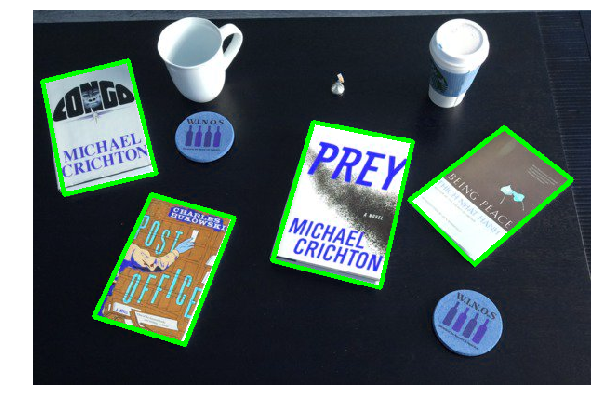

In [38]:
# цикл по контурам
for c in cnts:
    # аппроксимируем (сглаживаем) контур
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # если у контура 4 вершины, предполагаем, что это книга
    if len(approx) == 4:
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 4)
        total += 1

print("Я нашёл {0} книги на этой картинке.".format(total))
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image);